In [1]:
%load_ext autotime

time: 610 µs (started: 2021-12-31 19:43:26 +01:00)


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from bs4 import BeautifulSoup
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
from sklearn.metrics import confusion_matrix
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer


time: 7.92 s (started: 2021-12-31 19:43:26 +01:00)


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

time: 3.11 s (started: 2021-12-31 19:43:34 +01:00)


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'vs'])

time: 1.46 s (started: 2021-12-31 19:43:37 +01:00)


# 1 - Import Data

In [5]:
y = pd.read_csv('/Users/soso/Desktop/IML_P5/y_export_v2.csv', dtype=str) 
X = pd.read_csv('/Users/soso/Desktop/IML_P5/X_export_v2.csv', dtype=str) 

X = X.head(10000)
X

,Sentence
0,question intends technology agnostic kind web ...
1,python metaclasses use metaclasses python
2,logging lognet easy put class called log log f...
3,make facebook rss application autoupdates prov...
4,good regular expression validate text string m...
...,...
9995,one responses question asked yesterday suggest...
9996,building enterprise application net sql server...
9997,created vsto c supposed hook outlook newmailex...
9998,looking ideas elements user interface device m...


time: 1.78 s (started: 2021-12-31 19:43:38 +01:00)


# 2 - Cleaning

In [6]:
# Convert to list
data = X.Sentence.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['question intends technology agnostic kind web framework prefer pure mvc '
 'event driven component oriented make point technology agnosticism name mvc '
 'vs component web frameworks diverse technologies languages struts vs java '
 'server faces tapestry new asp net mvc vs classic asp net cake php vs prado '
 'mvc event driven component oriented web frameworks']
time: 1.72 s (started: 2021-12-31 19:43:40 +01:00)


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['question', 'intends', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'driven', 'component', 'oriented', 'make', 'point', 'technology', 'agnosticism', 'name', 'mvc', 'vs', 'component', 'web', 'frameworks', 'diverse', 'technologies', 'languages', 'struts', 'vs', 'java', 'server', 'faces', 'tapestry', 'new', 'asp', 'net', 'mvc', 'vs', 'classic', 'asp', 'net', 'cake', 'php', 'vs', 'prado', 'mvc', 'event', 'driven', 'component', 'oriented', 'web', 'frameworks']]
time: 6.07 s (started: 2021-12-31 19:43:42 +01:00)


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['question', 'intends', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'driven', 'component', 'oriented', 'make', 'point', 'technology', 'agnosticism', 'name', 'mvc', 'vs', 'component', 'web', 'frameworks', 'diverse', 'technologies', 'languages', 'struts', 'vs', 'java', 'server', 'faces', 'tapestry', 'new', 'asp_net_mvc', 'vs', 'classic_asp', 'net', 'cake', 'php', 'vs', 'prado', 'mvc', 'event', 'driven', 'component', 'oriented', 'web', 'frameworks']
time: 38.9 s (started: 2021-12-31 19:43:48 +01:00)


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

time: 4.27 ms (started: 2021-12-31 19:44:27 +01:00)


In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['question', 'intend', 'technology', 'agnostic', 'kind', 'web', 'framework', 'prefer', 'pure', 'mvc', 'event', 'drive', 'orient', 'make', 'point', 'technology', 'agnosticism', 'name', 'framework', 'diverse', 'technology', 'language', 'strut', 'face', 'new', 'net', 'event', 'drive', 'orient', 'web', 'framework']]
time: 2min 7s (started: 2021-12-31 19:44:27 +01:00)


# 3 - Prepare

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 2)]]
time: 2.28 s (started: 2021-12-31 19:46:34 +01:00)


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('agnostic', 1),
  ('agnosticism', 1),
  ('diverse', 1),
  ('drive', 2),
  ('event', 2),
  ('face', 1),
  ('framework', 3),
  ('intend', 1),
  ('kind', 1),
  ('language', 1),
  ('make', 1),
  ('mvc', 1),
  ('name', 1),
  ('net', 1),
  ('new', 1),
  ('orient', 2),
  ('point', 1),
  ('prefer', 1),
  ('pure', 1),
  ('question', 1),
  ('strut', 1),
  ('technology', 3),
  ('web', 2)]]

time: 18.2 ms (started: 2021-12-31 19:46:36 +01:00)


# 4 - Non-SuperVisée

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

time: 2min 12s (started: 2021-12-31 19:46:36 +01:00)


In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"service" + 0.046*"number" + 0.035*"request" + 0.033*"option" + '
  '0.033*"simple" + 0.032*"answer" + 0.030*"store" + 0.029*"format" + '
  '0.027*"handle" + 0.026*"long"'),
 (1,
  '0.211*"string" + 0.129*"text" + 0.089*"size" + 0.073*"item" + 0.049*"style" '
  '+ 0.042*"character" + 0.025*"clear" + 0.024*"actual" + 0.023*"mouse" + '
  '0.023*"render"'),
 (2,
  '0.288*"project" + 0.155*"key" + 0.085*"bit" + 0.077*"resource" + '
  '0.072*"visual_studio" + 0.041*"learn" + 0.036*"hope" + 0.032*"lock" + '
  '0.020*"sql" + 0.018*"range"'),
 (3,
  '0.156*"script" + 0.143*"library" + 0.111*"default" + 0.088*"framework" + '
  '0.079*"directory" + 0.064*"share" + 0.064*"copy" + 0.041*"determine" + '
  '0.033*"commit" + 0.022*"later"'),
 (4,
  '0.134*"form" + 0.108*"int" + 0.075*"main" + 0.066*"import" + 0.049*"state" '
  '+ 0.032*"become" + 0.031*"properly" + 0.031*"dependency" + 0.030*"socket" + '
  '0.030*"arg"'),
 (5,
  '0.300*"user" + 0.050*"click" + 0.049*"task" + 0.046*"butt

# 5 - Scoring

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.93372149791851

Coherence Score:  0.31615973371482037
time: 44.2 s (started: 2021-12-31 19:48:49 +01:00)


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.322774  0.092077       1        1  31.627283
18     0.298710  0.105689       2        1  14.699896
14     0.236899  0.053169       3        1   9.921586
0      0.066090 -0.299751       4        1   6.476635
7      0.073013 -0.317184       5        1   6.332523
12    -0.011724 -0.040075       6        1   3.463749
5     -0.047780  0.007381       7        1   2.470018
17    -0.029960  0.036422       8        1   2.449257
19    -0.050071  0.009485       9        1   2.382105
8     -0.059018  0.017540      10        1   2.344777
1     -0.052772  0.012034      11        1   2.322206
11    -0.062276  0.020344      12        1   2.266613
6     -0.074094  0.028910      13        1   2.104889
10    -0.051824  0.031592      14        1   1.908502
15    -0.081193  0.033376      15        1   1.840802
4     -0.091316  0.039132      16        1   1.683690
3     -0.098241  0.042401      17        1   1.500659
13    -0.085172  0.040843      18        1   1.500274
2     -0.091835  0.039301      19        1   1.478915
9     -0.110209  0.047315      20        1   1.225622, topic_info=           Term         Freq        Total Category  logprob  loglift
39         file  5788.000000  5788.000000  Default  30.0000  30.0000
102        user  3475.000000  3475.000000  Default  29.0000  29.0000
173         use  8449.000000  8449.000000  Default  28.0000  28.0000
215       table  2306.000000  2306.000000  Default  27.0000  27.0000
97       string  2299.000000  2299.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
0      agnostic    34.522923    35.675229  Topic20  -5.1155   4.3689
1092  ruby_rail    32.177977    33.330282  Topic20  -5.1858   4.3665
1076       poll    20.090754    21.243059  Topic20  -5.6569   4.3460
1078       proc    12.241781    13.394086  Topic20  -6.1523   4.3118
1074   finished     9.349439    10.501744  Topic20  -6.4218   4.2855

[692 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
398       1  0.998999     able
488       3  0.999444   access
137       4  0.996645  account
107       6  0.994021  achieve
1031      7  0.993542   action
...     ...       ...      ...
601      11  0.992434    worry
759      14  0.992821    worth
67        1  0.999767    would
176       1  0.999149    write
459       8  0.996563      xml

[598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 19, 15, 1, 8, 13, 6, 18, 20, 9, 2, 12, 7, 11, 16, 5, 4, 14, 3, 10])

time: 15.9 s (started: 2021-12-31 19:49:34 +01:00)


In [17]:
#from tqdm import tqdm
#
#def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#    coherence_values = []
#    model_list = []
#    for num_topics in range(start, limit, step):
#        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=id2word,
#                                           num_topics=num_topics)
#        model_list.append(model)
#        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#        coherence_values.append(coherencemodel.get_coherence())
#        print('num_topics :' , num_topics ,"   coherence_values :",coherencemodel.get_coherence() )
#
#    return model_list, coherence_values

time: 1.28 ms (started: 2021-12-31 19:49:50 +01:00)


In [18]:
# Can take a long time to run.
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)

time: 643 µs (started: 2021-12-31 19:49:50 +01:00)


In [19]:
data = [[2 ,  0.3842037125943148  ],
[3 ,  0.37529301525610065],
[4 ,  0.36527094841598623],
[5 ,  0.3786268856718328],
[6 ,  0.37041288938196143],
[7 ,  0.39334922220555985],
[8 ,  0.3636774759058625],
[9 ,  0.37541064100691635],
[10,  0.3468006225561583],
[11,  0.3951863472705606],
[12,  0.39039081366178335],
[13,  0.38642361599425884],
[14,  0.3527335559298688],
[15,  0.3856383217897125],
[16,  0.3730077364356735],
[17,  0.3736232396518417],
[18,  0.38321713621364045],
[19,  0.3687004828119065]]

time: 23.5 ms (started: 2021-12-31 19:49:50 +01:00)


In [20]:
df = pd.DataFrame(data)
df = df.rename(columns={0: "Nb Topics", 1: "Coherance_Score"})
df

,Nb Topics,Coherance_Score
0,2,0.384204
1,3,0.375293
2,4,0.365271
3,5,0.378627
4,6,0.370413
5,7,0.393349
6,8,0.363677
7,9,0.375411
8,10,0.346801
9,11,0.395186


time: 20 ms (started: 2021-12-31 19:49:50 +01:00)


# 6 - Visualisation

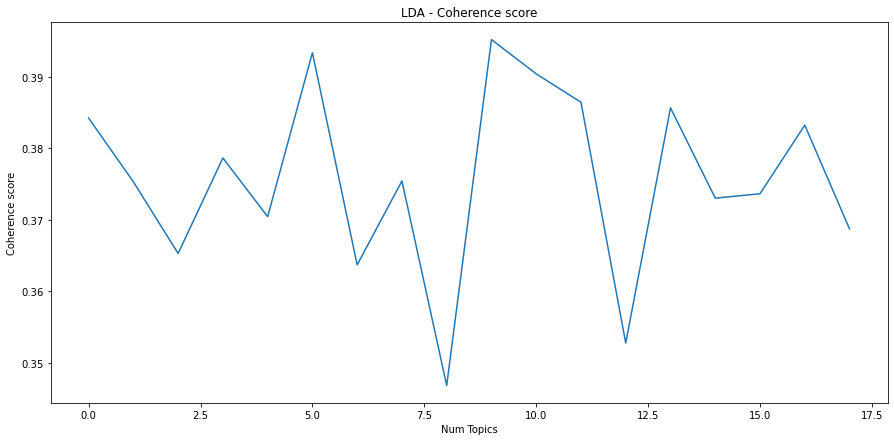

time: 500 ms (started: 2021-12-31 19:49:50 +01:00)


In [21]:
plt.figure(figsize=(15,7))
plt.plot(df.Coherance_Score)
plt.ylabel('Coherence score')
plt.xlabel('Num Topics')
plt.title('LDA - Coherence score')
plt.show()

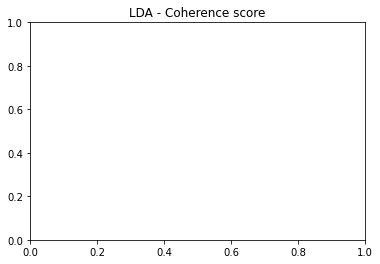

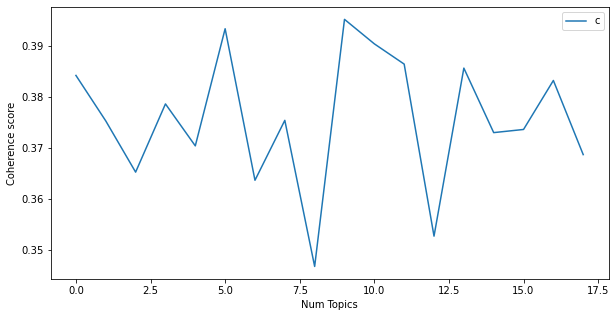

time: 709 ms (started: 2021-12-31 19:49:50 +01:00)


In [22]:
plt.title("LDA - Coherence score")
plt.figure(figsize=(10,5))
plt.plot(df.Coherance_Score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.show()

In [23]:
# Best Model 9 topics

time: 457 µs (started: 2021-12-31 19:49:51 +01:00)


## 6.1 - Best Model

In [24]:
# Build LDA model
num_topics = 9
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 9 topics
print(lda_model.print_topics())

[(0, '0.063*"would" + 0.033*"good" + 0.027*"look" + 0.022*"control" + 0.022*"question" + 0.018*"service" + 0.013*"think" + 0.013*"library" + 0.013*"request" + 0.012*"different"'), (1, '0.046*"user" + 0.033*"server" + 0.032*"web" + 0.028*"page" + 0.026*"error" + 0.018*"message" + 0.018*"system" + 0.016*"access" + 0.016*"content" + 0.015*"site"'), (2, '0.071*"application" + 0.056*"run" + 0.048*"project" + 0.045*"net" + 0.032*"build" + 0.025*"version" + 0.017*"machine" + 0.014*"feature" + 0.013*"thread" + 0.013*"development"'), (3, '0.154*"table" + 0.060*"column" + 0.055*"row" + 0.028*"performance" + 0.027*"setting" + 0.017*"css" + 0.017*"root" + 0.015*"duplicate" + 0.013*"windows_form" + 0.013*"focus"'), (4, '0.049*"class" + 0.044*"object" + 0.035*"call" + 0.035*"method" + 0.028*"function" + 0.018*"result" + 0.015*"query" + 0.015*"log" + 0.013*"contain" + 0.013*"implement"'), (5, '0.117*"window" + 0.042*"interface" + 0.037*"print" + 0.036*"click" + 0.036*"task" + 0.035*"parameter" + 0.03

In [25]:
a = lda_model.print_topics()
b = pd.DataFrame(a)
b

,0,1
0,0,"0.063*""would"" + 0.033*""good"" + 0.027*""look"" + ..."
1,1,"0.046*""user"" + 0.033*""server"" + 0.032*""web"" + ..."
2,2,"0.071*""application"" + 0.056*""run"" + 0.048*""pro..."
3,3,"0.154*""table"" + 0.060*""column"" + 0.055*""row"" +..."
4,4,"0.049*""class"" + 0.044*""object"" + 0.035*""call"" ..."
5,5,"0.117*""window"" + 0.042*""interface"" + 0.037*""pr..."
6,6,"0.053*""test"" + 0.047*""process"" + 0.041*""take"" ..."
7,7,"0.060*""value"" + 0.053*""type"" + 0.053*""string"" ..."
8,8,"0.039*""use"" + 0.028*""file"" + 0.024*""way"" + 0.0..."


time: 33 ms (started: 2021-12-31 19:51:31 +01:00)


In [26]:
c = b[1].str.split('"', expand=True)
c

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.063*,would,+ 0.033*,good,+ 0.027*,look,+ 0.022*,control,+ 0.022*,question,...,service,+ 0.013*,think,+ 0.013*,library,+ 0.013*,request,+ 0.012*,different,
1,0.046*,user,+ 0.033*,server,+ 0.032*,web,+ 0.028*,page,+ 0.026*,error,...,message,+ 0.018*,system,+ 0.016*,access,+ 0.016*,content,+ 0.015*,site,
2,0.071*,application,+ 0.056*,run,+ 0.048*,project,+ 0.045*,net,+ 0.032*,build,...,version,+ 0.017*,machine,+ 0.014*,feature,+ 0.013*,thread,+ 0.013*,development,
3,0.154*,table,+ 0.060*,column,+ 0.055*,row,+ 0.028*,performance,+ 0.027*,setting,...,css,+ 0.017*,root,+ 0.015*,duplicate,+ 0.013*,windows_form,+ 0.013*,focus,
4,0.049*,class,+ 0.044*,object,+ 0.035*,call,+ 0.035*,method,+ 0.028*,function,...,result,+ 0.015*,query,+ 0.015*,log,+ 0.013*,contain,+ 0.013*,implement,
5,0.117*,window,+ 0.042*,interface,+ 0.037*,print,+ 0.036*,click,+ 0.036*,task,...,parameter,+ 0.034*,path,+ 0.034*,button,+ 0.030*,child,+ 0.017*,security,
6,0.053*,test,+ 0.047*,process,+ 0.041*,take,+ 0.033*,tool,+ 0.027*,order,...,tag,+ 0.017*,record,+ 0.017*,software,+ 0.016*,insert,+ 0.015*,comment,
7,0.060*,value,+ 0.053*,type,+ 0.053*,string,+ 0.051*,return,+ 0.050*,name,...,public,+ 0.031*,d,+ 0.027*,key,+ 0.026*,property,+ 0.025*,select,
8,0.039*,use,+ 0.028*,file,+ 0.024*,way,+ 0.020*,work,+ 0.018*,want,...,code,+ 0.017*,need,+ 0.015*,set,+ 0.015*,get,+ 0.014*,create,


time: 73.8 ms (started: 2021-12-31 19:51:31 +01:00)


In [27]:
for i in range (0,21,2):
    c.pop(i)

time: 22.4 ms (started: 2021-12-31 19:51:32 +01:00)


In [28]:
k=1
for i in range (1,21,2):
    new_col = "Word_" + str(k)
    c = c.rename(columns={i: new_col})
    k +=1

time: 19.9 ms (started: 2021-12-31 19:51:32 +01:00)


# 7 - Result

In [29]:
Topics = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6','Topic_7', 'Topic_8', 'Topic_9']
 
# Using 'Address' as the column name
# and equating it to the list
c['Topics'] = Topics
c = c.set_index('Topics')
c

,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
Topics,,,,,,,,,,
Topic_1,would,good,look,control,question,service,think,library,request,different
Topic_2,user,server,web,page,error,message,system,access,content,site
Topic_3,application,run,project,net,build,version,machine,feature,thread,development
Topic_4,table,column,row,performance,setting,css,root,duplicate,windows_form,focus
Topic_5,class,object,call,method,function,result,query,log,contain,implement
Topic_6,window,interface,print,click,task,parameter,path,button,child,security
Topic_7,test,process,take,tool,order,tag,record,software,insert,comment
Topic_8,value,type,string,return,name,public,d,key,property,select
Topic_9,use,file,way,work,want,code,need,set,get,create


time: 1.77 s (started: 2021-12-31 19:51:32 +01:00)


# 8 - Semi-SuperVisé

In [31]:
XY = pd.read_csv('/Users/soso/Desktop/IML_P5/export_clean_df.csv', dtype=str) 
XY

,Txt_Clean,Tags_Clean
0,python metaclasses use,python oop metaclass class datamodel
1,good regular expression validate text string m...,c regex
2,two unsorted lists need produce another list s...,algorithm sort lisp list
3,tools like selenium good testing user interact...,test browser user interface
4,like know easier way insert record already exi...,c linq sql
...,...,...
38897,company perl application server ip new rule im...,mysql perl mariadb dbi
38898,typescript compiler compile optional chaining ...,typescript language design
38899,using mockk spy kotlin java class field anonym...,kotlin mockk
38900,hoping try cro library raku https services doc...,raku cro


time: 385 ms (started: 2021-12-31 20:12:24 +01:00)


In [32]:
y = pd.DataFrame(XY.Tags_Clean)
X = pd.DataFrame(XY.Txt_Clean)

time: 95 ms (started: 2021-12-31 20:12:24 +01:00)


In [33]:
x_feat = 3439
vetorizar = TfidfVectorizer(max_features=x_feat) 
X = pd.DataFrame(vetorizar.fit_transform(X.Txt_Clean).toarray())
print(X.shape)

(38902, 3439)
time: 3.07 s (started: 2021-12-31 20:12:25 +01:00)


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
y_feat = 100
vectorizer = CountVectorizer(max_features=y_feat)
y = pd.DataFrame(vectorizer.fit_transform(y.Tags_Clean).toarray(), columns=vectorizer.get_feature_names())
print(y.shape)

(38902, 100)
time: 341 ms (started: 2021-12-31 20:12:28 +01:00)


In [44]:
#Model
from sklearn.decomposition import LatentDirichletAllocation as LDA

model = LDA(n_components=9)
# Fit the model to TF-IDF
model.fit_transform(X)
# Transform the TF-IDF: nmf_features
lda_features = model.transform(X)

time: 3min 8s (started: 2021-12-31 20:19:23 +01:00)


In [45]:
def avg_jacard(y_true,y_pred):
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)    
    return jacard.mean()*100

    
def print_score(y_pred, y_test):
    print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
    print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
    print("Micro f1 score :",metrics.f1_score(y_test, y_pred, average = 'micro'))
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(metrics.hamming_loss(y_pred, y_test)*100))
    print("---")

time: 2.54 ms (started: 2021-12-31 20:22:32 +01:00)


In [46]:
lda_features_df = pd.DataFrame(lda_features)

print(y.shape)
print(lda_features_df.shape)

X_train =  lda_features_df.iloc[0:10000]
X_test =  lda_features_df.iloc[10000:20000]
y_train = y.iloc[0:10000]
y_test = y.iloc[10000:20000]


print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

(38902, 100)
(38902, 9)
X_train : (10000, 9)
X_test : (10000, 9)
y_train : (10000, 100)
y_test : (10000, 100)
time: 3.19 ms (started: 2021-12-31 20:22:32 +01:00)


In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from datetime import datetime

model_1 = SGDClassifier(alpha=1e-05, loss='log')
model_2 = LogisticRegression(max_iter=10000)
model_3 = ExtraTreesClassifier()
model_4 = RandomForestClassifier(n_estimators=50, random_state=0)
model_5 = LGBMClassifier() 
model_6 = LinearSVC(class_weight='balanced', max_iter=10000)


print(str(model_1),'  ', datetime.now().strftime("%H:%M:%S"))
clf_1 = OneVsRestClassifier(model_1)
clf_1.fit(X_train, y_train)
y_pred = clf_1.predict(X_test)
print_score(y_pred,y_test)

print(str(model_2),'  ', datetime.now().strftime("%H:%M:%S"))
clf_2 = OneVsRestClassifier(model_2)
clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)
print_score(y_pred,y_test)

print(str(model_3),'  ', datetime.now().strftime("%H:%M:%S"))
clf_3 = OneVsRestClassifier(model_3)
clf_3.fit(X_train, y_train)
y_pred = clf_3.predict(X_test)
print_score(y_pred,y_test)

print(str(model_4),'  ', datetime.now().strftime("%H:%M:%S"))
clf_4 = OneVsRestClassifier(model_4)
clf_4.fit(X_train, y_train)
y_pred = clf_4.predict(X_test)
print_score(y_pred,y_test)

print(str(model_5),'  ', datetime.now().strftime("%H:%M:%S"))
clf_5 = OneVsRestClassifier(model_5)
clf_5.fit(X_train, y_train)
y_pred = clf_5.predict(X_test)
print_score(y_pred,y_test)

print(str(model_6),'  ', datetime.now().strftime("%H:%M:%S"))
clf_6 = OneVsRestClassifier(model_6)
clf_6.fit(X_train, y_train)
y_pred = clf_6.predict(X_test)
print_score(y_pred,y_test)



SGDClassifier(alpha=1e-05, loss='log')    21:25:23
Accuracy : 0.1662
Macro f1 score : 0.007473306083926854
Micro f1 score : 0.039856801909307876
Jacard score: 1.4721590380036431
Hamming loss: 1.6092
---
LogisticRegression(max_iter=10000)    21:25:29
Accuracy : 0.1695
Macro f1 score : 0.004694793400363269
Micro f1 score : 0.03649283391545225
Jacard score: 1.2979519180767238
Hamming loss: 1.6
---
ExtraTreesClassifier()    21:25:37
Accuracy : 0.095
Macro f1 score : 0.03558237924018305
Micro f1 score : 0.07851974854702883
Jacard score: 4.160572639591705
Hamming loss: 2.3307
---
RandomForestClassifier(n_estimators=50, random_state=0)    21:28:09
Accuracy : 0.1352
Macro f1 score : 0.024201817639904206
Micro f1 score : 0.07114126484128906
Jacard score: 3.3790664511318265
Hamming loss: 1.9167
---
LGBMClassifier()    21:31:24
Accuracy : 0.1471
Macro f1 score : 0.019619415193134256
Micro f1 score : 0.05237001015336931
Jacard score: 2.14650882513024
Hamming loss: 1.7732999999999999
---
LinearSVC(

In [51]:
def _my_score_(idx):
    row_pred_1 = pd.DataFrame(y_pred_df.iloc[idx])
    row_pred_1 = row_pred_1.sort_values(by=[idx], ascending=False)
    row_pred_2 = row_pred_1.head(3)
    row_pred_2 = row_pred_2.reset_index()
    row_pred_2.pop(idx)
    row_pred_2 = row_pred_2.rename(columns={'level_0': "Find_tag"})
    row_pred_val = row_pred_2.Find_tag.values
    row_pred_val = row_pred_val.tolist()
    len_pred_val = len(row_pred_val)
    # ---
    y_test_1 = pd.DataFrame(y_test).reset_index()
    y_test_1.pop('index')
    row_test_1 = pd.DataFrame(y_test_1.iloc[idx])
    row_test_1 = row_test_1[row_test_1[idx] > 0]
    row_test_1 = row_test_1.reset_index()
    row_test_1.pop(idx)
    row_test_1 = row_test_1.rename(columns={'index': "Real_tag"})
    row_real_val = row_test_1.Real_tag.values
    row_real_val = row_real_val.tolist()
    len_real_val = len(row_real_val)
    #----
    compare = set(row_pred_val) & set(row_real_val)
    len_compare_ok  = len(compare)
    #----
    row.append([len_pred_val,len_real_val,len_compare_ok])

time: 19.1 ms (started: 2021-12-31 21:46:31 +01:00)


In [52]:
_len_ = y_test.shape[0]


lst_mod = [clf_1, clf_2,clf_3,clf_4,clf_5]
for xXx in lst_mod:
    print(xXx)
    y_proba_df = xXx.predict_proba(X_test)
    y_pred_df = pd.DataFrame(y_proba_df, columns=[y.columns])
    row = []
    for i in range(_len_):
        _my_score_(i)
    eval_df = pd.DataFrame(row, columns=['Pred','Real','Match'])
    eval_df['Eval'] = eval_df['Match'] / eval_df['Real']
    _eval_val = eval_df.Eval.mean(axis = 0)

    print('My Score : ' , _eval_val)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log'))
My Score :  0.21952871367771312
OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))
My Score :  0.26434923885237055
OneVsRestClassifier(estimator=ExtraTreesClassifier())
My Score :  0.1535255417512706
OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                     random_state=0))
My Score :  0.16628035699946084
OneVsRestClassifier(estimator=LGBMClassifier())
My Score :  0.20066077021027612
time: 12min 20s (started: 2021-12-31 21:46:36 +01:00)


In [ ]:
data = [["SGDClassifier - Semi - LDA",0.21,0.16,0.00,0.03,1, 1.60,1],
["LogisticRegression - Semi - LDA", 0.26,0.16,0.00,0.03,1, 1.6,1],
["ExtraTreesClassifier - Semi - LDA",0.15,0.09,0.03,0.07,4,2.33,1],
["RandomForestClassifier - Semi - LDA",0.16,0.13,0.02,0.07,3,1.91,1],
["LGBMClassifier - Semi - LDA",0.20,0.14,0.01,0.05,2,1.77,1]]
